In [118]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [119]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(1)
torch.manual_seed(0)

In [120]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# # detection parameters
# to_localize = True
# cutout_start = 14
# cutout_end = 36
# threshold = 18
# file_directory = 'results/'
# file_name = 'ProcessedSpikes_visapy'

# Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
# H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
#                 maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
#                 file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


In [5]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

# Data Prepping and Split

In [121]:
# length = H.spikes['Shape'][0].shape[0]
# total_sigs = H.spikes['Shape'].shape[0]

# electrode_data = np.zeros([total_sigs, length])
# list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

# for i in list_of_sigs:
#     electrode_data[i, :] = H.spikes['Shape'][i]
# print(electrode_data.shape)

electrode_data = np.load(data_path)
electrode_data = electrode_data.reshape(1200001, 102)
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (960000, 102)
Test Datasize: (240001, 102)


In [122]:
print(electrode_data)

[[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


# Helper Functions

In [8]:
def find_scaled_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.var(original[i, :])
        mse.append(np.mean(se))
    mse = np.array(mse)

In [9]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [10]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(10,10))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=True, notch=False)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

In [114]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    for i in keys:
        print(i, np.mean(corrs[i]))
    gen_boxplots(corrs)

In [12]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [92]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], length])

    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data)
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]

    return enc_final, out_final

# DEFINING MODELS

In [45]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        x = np.zeros((batch_size, 51))
        for i, feats in enumerate(selected):
            x[i, :] = input_data[feats, :]
        x = torch.from_numpy(x).float().cuda()
        #---------FORWARD------------#
        enc, out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, x)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, avg:{:.8f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple Shallow

In [20]:
# input -> 50 -> 12 -> emb -> 12 -> 50 -> input

class autoencoder_1(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_1, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 50),
                                     activation_layer,
                                     nn.Linear(50, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 50),
                                     activation_layer,
                                     nn.Linear(50, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [24]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 100000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_14 = autoencoder_1(length, embedding_size).cuda()
ae_14.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_12 = autoencoder_1(length, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12 = train_ae(ae_12, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/new_data_models/losses_1_4', np.array(losses_14))
np.save('models/new_data_models/losses_1_2', np.array(losses_12))


# Saving Models
torch.save(ae_14, 'models/new_data_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_12, 'models/new_data_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 6575
epoch [1/1000000], loss:1811.48633, avg:1811.48633
epoch [101/1000000], loss:1702.24780, avg:1577.82324
epoch [201/1000000], loss:1302.67029, avg:1300.95154
epoch [301/1000000], loss:957.01013, avg:982.70081
epoch [401/1000000], loss:639.86414, avg:657.92609
epoch [501/1000000], loss:376.83017, avg:444.42682
epoch [601/1000000], loss:340.04553, avg:329.36069
epoch [701/1000000], loss:241.36353, avg:257.89587
epoch [801/1000000], loss:244.43788, avg:244.39134
epoch [901/1000000], loss:216.15262, avg:232.51367
epoch [1001/1000000], loss:240.95673, avg:228.09109
epoch [1101/1000000], loss:219.17805, avg:228.68382
epoch [1201/1000000], loss:229.78899, avg:214.43115
epoch [1301/1000000], loss:155.04753, avg:199.12169
epoch [1401/1000000], loss:179.76700, avg:190.12474
epoch [1501/1000000], loss:176.33415, avg:179.48009
epoch [1601/1000000], loss:176.11559, avg:169.67464
epoch [1701/1000000], loss:165.41435, avg:154.75304
epoch [1801/1000000], loss:145.28342,

epoch [16101/1000000], loss:75.85440, avg:71.01688
epoch [16201/1000000], loss:69.04016, avg:74.66509
epoch [16301/1000000], loss:66.04747, avg:73.05039
epoch [16401/1000000], loss:67.90910, avg:71.36672
epoch [16501/1000000], loss:81.53234, avg:73.09349
epoch [16601/1000000], loss:74.28097, avg:72.77055
epoch [16701/1000000], loss:77.19129, avg:74.32635
epoch [16801/1000000], loss:76.81489, avg:72.22878
epoch [16901/1000000], loss:74.10194, avg:72.29185
epoch [17001/1000000], loss:80.97153, avg:72.33776
epoch [17101/1000000], loss:75.16048, avg:73.09753
epoch [17201/1000000], loss:73.13067, avg:72.93953
epoch [17301/1000000], loss:70.58444, avg:73.25571
epoch [17401/1000000], loss:71.41014, avg:73.72265
epoch [17501/1000000], loss:67.92536, avg:73.32618
epoch [17601/1000000], loss:73.30753, avg:71.36066
epoch [17701/1000000], loss:72.27103, avg:73.29733
epoch [17801/1000000], loss:77.85588, avg:74.70298
epoch [17901/1000000], loss:69.72502, avg:73.99709
epoch [18001/1000000], loss:73.

KeyboardInterrupt: 

In [ ]:
ae_1 = torch.load('models/new_data_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/new_data_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

PCA 0.2424215458662489


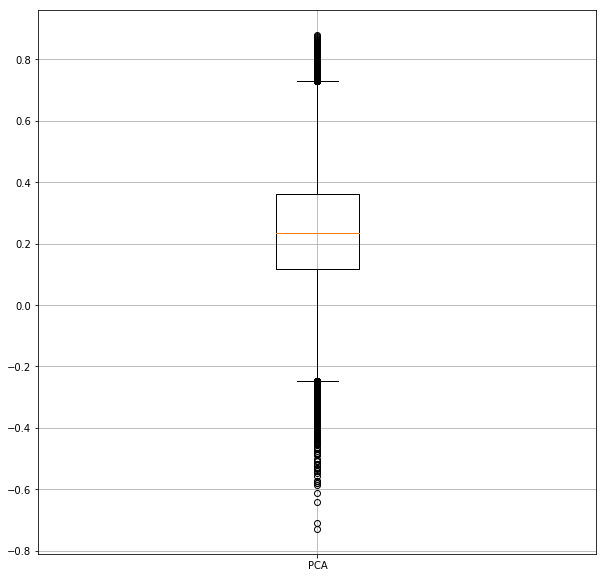

In [124]:
#_, out2 = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'PCA': out_pca}
find_correlation_coeff(d)

## Simple Deep

In [89]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_4(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_4, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 50),
                                     activation_layer,
                                     nn.Linear(50, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [ ]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 100000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_44 = autoencoder_4(length, embedding_size).cuda()
ae_44.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

epoch_range = 4000
batch_size = 150
learning_rate = 0.0001
embedding_size = 2

ae_42 = autoencoder_4(length, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42 = train_ae(ae_42, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/new_data_models/losses_4_4', np.array(losses_44))
np.save('models/new_data_models/losses_4_2', np.array(losses_42))


# Saving Models
torch.save(ae_44, 'models/new_data_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_42, 'models/new_data_models/ae_4_2.pt') #Saving the autoencoder model

In [ ]:
ae_1 = torch.load('models/new_data_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/new_data_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

## Deep Encoder - Shallow Decoder Variation 1

In [27]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_5(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_5, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 80),
                                     activation_layer,
                                     nn.Linear(80, 40),
                                     activation_layer,
                                     nn.Linear(40, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 10),
                                     activation_layer,
                                     nn.Linear(10, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [87]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 100000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_54 = autoencoder_5(length, embedding_size).cuda()
ae_54.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_5(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52 = train_ae(ae_52, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/new_data_models/losses_5_4', np.array(losses_54))
np.save('models/new_data_models/losses_5_2', np.array(losses_52))


# Saving Models
torch.save(ae_54, 'models/new_data_models/ae_5_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/new_data_models/ae_5_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 15555
epoch [1/100000], loss:1864.72741699, avg:1864.72741699
epoch [101/100000], loss:1189.02697754, avg:1189.95678711
epoch [201/100000], loss:368.61221313, avg:373.52044678
epoch [301/100000], loss:247.54394531, avg:244.56970215
epoch [401/100000], loss:223.06471252, avg:230.59948730
epoch [501/100000], loss:226.18583679, avg:221.26029968
epoch [601/100000], loss:194.96670532, avg:199.49331665
epoch [701/100000], loss:168.31593323, avg:174.33250427
epoch [801/100000], loss:161.39512634, avg:155.42185974
epoch [901/100000], loss:148.16946411, avg:155.08145142
epoch [1001/100000], loss:140.57211304, avg:148.64692688
epoch [1101/100000], loss:146.59994507, avg:145.21160889
epoch [1201/100000], loss:149.95542908, avg:145.58396912
epoch [1301/100000], loss:151.76025391, avg:147.38072205
epoch [1401/100000], loss:138.52586365, avg:145.29304504
epoch [1501/100000], loss:134.11877441, avg:145.19198608
epoch [1601/100000], loss:146.92428589, avg:144.81089783
epoch

epoch [14501/100000], loss:92.12028503, avg:93.85155487
epoch [14601/100000], loss:90.83766174, avg:92.99431610
epoch [14701/100000], loss:96.51840210, avg:94.30346680
epoch [14801/100000], loss:90.97150421, avg:93.47234344
epoch [14901/100000], loss:94.34445953, avg:93.65598297
epoch [15001/100000], loss:92.64987946, avg:93.35438538
epoch [15101/100000], loss:91.25567627, avg:93.68721008
epoch [15201/100000], loss:95.25205994, avg:92.56662750
epoch [15301/100000], loss:94.70881653, avg:93.27306366
epoch [15401/100000], loss:91.74834442, avg:94.02750397
epoch [15501/100000], loss:95.85173035, avg:92.67156219
epoch [15601/100000], loss:87.40781403, avg:94.01383972
epoch [15701/100000], loss:91.69718933, avg:92.90163422
epoch [15801/100000], loss:90.01544189, avg:93.46916962
epoch [15901/100000], loss:92.38465881, avg:90.99565125
epoch [16001/100000], loss:88.56141663, avg:91.81078339
epoch [16101/100000], loss:93.77995300, avg:93.94618988
epoch [16201/100000], loss:91.64614868, avg:92.3

epoch [29201/100000], loss:72.36138916, avg:72.69143677
epoch [29301/100000], loss:70.36093903, avg:71.11461639
epoch [29401/100000], loss:75.01033020, avg:73.13040924
epoch [29501/100000], loss:73.63279724, avg:72.40636444
epoch [29601/100000], loss:71.93943787, avg:72.78732300
epoch [29701/100000], loss:70.03588104, avg:71.70113373
epoch [29801/100000], loss:66.99457550, avg:72.13027954
epoch [29901/100000], loss:68.32521057, avg:71.25487518
epoch [30001/100000], loss:68.19281006, avg:70.20198822
epoch [30101/100000], loss:73.88634491, avg:72.58518219
epoch [30201/100000], loss:74.44761658, avg:71.87908173
epoch [30301/100000], loss:69.36107635, avg:71.93495941
epoch [30401/100000], loss:72.97593689, avg:72.03340912
epoch [30501/100000], loss:76.35269928, avg:72.55413818
epoch [30601/100000], loss:73.12722015, avg:71.75524902
epoch [30701/100000], loss:68.67617035, avg:70.95724487
epoch [30801/100000], loss:69.90885162, avg:71.96442413
epoch [30901/100000], loss:69.71513367, avg:71.8

epoch [43901/100000], loss:70.18758392, avg:70.35225677
epoch [44001/100000], loss:66.44197083, avg:69.29644012
epoch [44101/100000], loss:71.45624542, avg:70.01161957
epoch [44201/100000], loss:69.85985565, avg:69.87950897
epoch [44301/100000], loss:68.83153534, avg:70.26335907
epoch [44401/100000], loss:66.88381195, avg:69.41064453
epoch [44501/100000], loss:67.81854248, avg:69.88240814
epoch [44601/100000], loss:70.01450348, avg:69.87265015
epoch [44701/100000], loss:68.57444000, avg:70.05438232
epoch [44801/100000], loss:68.93906403, avg:69.95417786
epoch [44901/100000], loss:69.17914581, avg:69.23536682
epoch [45001/100000], loss:68.81236267, avg:69.35001373
epoch [45101/100000], loss:71.95993805, avg:69.70144653
epoch [45201/100000], loss:69.46224976, avg:70.13545990
epoch [45301/100000], loss:71.28708649, avg:69.75608063
epoch [45401/100000], loss:70.63382721, avg:69.68732452
epoch [45501/100000], loss:70.41766357, avg:70.23970795
epoch [45601/100000], loss:68.05620575, avg:68.7

epoch [58601/100000], loss:67.33630371, avg:68.14306641
epoch [58701/100000], loss:68.19309235, avg:68.28849030
epoch [58801/100000], loss:67.46549988, avg:67.99108124
epoch [58901/100000], loss:69.24297333, avg:69.10427094
epoch [59001/100000], loss:67.65076447, avg:68.44699860
epoch [59101/100000], loss:68.13626862, avg:67.35724640
epoch [59201/100000], loss:70.36070251, avg:67.76737213
epoch [59301/100000], loss:68.32036591, avg:68.41878510
epoch [59401/100000], loss:68.46392822, avg:68.53731537
epoch [59501/100000], loss:66.06233215, avg:68.62754059
epoch [59601/100000], loss:69.36706543, avg:67.74526978
epoch [59701/100000], loss:69.23744202, avg:68.14203644
epoch [59801/100000], loss:66.74875641, avg:68.91101074
epoch [59901/100000], loss:66.63600159, avg:67.24447632
epoch [60001/100000], loss:66.75589752, avg:68.14883423
epoch [60101/100000], loss:65.43373108, avg:66.78797150
epoch [60201/100000], loss:68.70339966, avg:68.32893372
epoch [60301/100000], loss:71.75212097, avg:68.6

epoch [73301/100000], loss:66.89176941, avg:67.55647278
epoch [73401/100000], loss:68.47776794, avg:66.14967346
epoch [73501/100000], loss:67.96684265, avg:67.20463562
epoch [73601/100000], loss:64.01339722, avg:66.60857391
epoch [73701/100000], loss:67.05940247, avg:66.49719238
epoch [73801/100000], loss:64.00681305, avg:66.94702148
epoch [73901/100000], loss:68.73511505, avg:66.02617645
epoch [74001/100000], loss:67.98285675, avg:67.21819305
epoch [74101/100000], loss:63.85054779, avg:65.98993683
epoch [74201/100000], loss:66.28504944, avg:66.93401337
epoch [74301/100000], loss:67.09542084, avg:66.68649292
epoch [74401/100000], loss:66.32376862, avg:66.34899139
epoch [74501/100000], loss:64.73030853, avg:66.40291595
epoch [74601/100000], loss:65.50355530, avg:65.83056641
epoch [74701/100000], loss:69.82427979, avg:66.37034607
epoch [74801/100000], loss:66.37739563, avg:65.80534363
epoch [74901/100000], loss:66.43848419, avg:66.12664795
epoch [75001/100000], loss:65.16843414, avg:65.9

epoch [88001/100000], loss:65.36500549, avg:64.99375916
epoch [88101/100000], loss:64.86421204, avg:65.11358643
epoch [88201/100000], loss:63.16678619, avg:66.38805389
epoch [88301/100000], loss:63.91055679, avg:65.33146667
epoch [88401/100000], loss:69.10865784, avg:66.54996490
epoch [88501/100000], loss:65.89479065, avg:65.58335876
epoch [88601/100000], loss:63.67045975, avg:65.45884705
epoch [88701/100000], loss:63.00598907, avg:65.62784576
epoch [88801/100000], loss:64.88949585, avg:65.49796295
epoch [88901/100000], loss:67.53162384, avg:66.59362030
epoch [89001/100000], loss:66.91647339, avg:65.96306610
epoch [89101/100000], loss:65.00965881, avg:65.28971100
epoch [89201/100000], loss:64.15029907, avg:64.98453522
epoch [89301/100000], loss:65.24034882, avg:64.92759705
epoch [89401/100000], loss:65.20526123, avg:64.21853638
epoch [89501/100000], loss:63.24639130, avg:65.52459717
epoch [89601/100000], loss:68.91040802, avg:66.13729858
epoch [89701/100000], loss:62.40867996, avg:64.7

epoch [2601/100000], loss:128.50407410, avg:140.41099548
epoch [2701/100000], loss:135.85122681, avg:143.59280396
epoch [2801/100000], loss:140.72351074, avg:141.87150574
epoch [2901/100000], loss:138.31333923, avg:138.67430115
epoch [3001/100000], loss:140.54444885, avg:139.34710693
epoch [3101/100000], loss:139.57888794, avg:143.63687134
epoch [3201/100000], loss:147.31550598, avg:143.00733948
epoch [3301/100000], loss:143.95516968, avg:139.89064026
epoch [3401/100000], loss:143.52888489, avg:140.98812866
epoch [3501/100000], loss:141.31527710, avg:139.00816345
epoch [3601/100000], loss:141.81779480, avg:139.51959229
epoch [3701/100000], loss:129.72740173, avg:140.04179382
epoch [3801/100000], loss:137.67407227, avg:139.04702759
epoch [3901/100000], loss:136.86613464, avg:140.52421570
epoch [4001/100000], loss:133.43751526, avg:138.02195740
epoch [4101/100000], loss:136.35601807, avg:140.13171387
epoch [4201/100000], loss:132.78671265, avg:137.81181335
epoch [4301/100000], loss:130.1

epoch [16901/100000], loss:133.09484863, avg:127.41778564
epoch [17001/100000], loss:124.32687378, avg:131.76156616
epoch [17101/100000], loss:125.83986664, avg:131.90878296
epoch [17201/100000], loss:134.70370483, avg:131.30377197
epoch [17301/100000], loss:131.30003357, avg:129.66723633
epoch [17401/100000], loss:122.14960480, avg:130.11119080
epoch [17501/100000], loss:136.77760315, avg:130.39926147
epoch [17601/100000], loss:127.78526306, avg:130.90510559
epoch [17701/100000], loss:130.10671997, avg:127.69130707
epoch [17801/100000], loss:133.58906555, avg:131.24748230
epoch [17901/100000], loss:116.89253235, avg:130.08758545
epoch [18001/100000], loss:125.62491608, avg:131.19024658
epoch [18101/100000], loss:137.57438660, avg:131.03315735
epoch [18201/100000], loss:136.74795532, avg:129.47502136
epoch [18301/100000], loss:126.20274353, avg:128.19589233
epoch [18401/100000], loss:136.53323364, avg:129.52169800
epoch [18501/100000], loss:135.10964966, avg:127.11811829
epoch [18601/1

epoch [31101/100000], loss:115.50415039, avg:116.96779633
epoch [31201/100000], loss:117.46717072, avg:122.84886932
epoch [31301/100000], loss:116.68299103, avg:117.08235168
epoch [31401/100000], loss:120.26321411, avg:121.59018707
epoch [31501/100000], loss:129.95301819, avg:119.49489594
epoch [31601/100000], loss:120.21748352, avg:118.74751282
epoch [31701/100000], loss:122.27443695, avg:120.60156250
epoch [31801/100000], loss:122.36512756, avg:119.20381165
epoch [31901/100000], loss:122.73756409, avg:119.75670624
epoch [32001/100000], loss:119.63191223, avg:120.07848358
epoch [32101/100000], loss:116.26803589, avg:118.65316010
epoch [32201/100000], loss:123.55715179, avg:118.99419403
epoch [32301/100000], loss:118.03048706, avg:117.97129059
epoch [32401/100000], loss:110.24447632, avg:116.13616943
epoch [32501/100000], loss:116.77649689, avg:116.81649017
epoch [32601/100000], loss:118.86289215, avg:118.14080048
epoch [32701/100000], loss:117.19557953, avg:119.16773987
epoch [32801/1

epoch [45301/100000], loss:114.48152161, avg:115.51861572
epoch [45401/100000], loss:114.00128937, avg:116.89035797
epoch [45501/100000], loss:112.23389435, avg:115.69331360
epoch [45601/100000], loss:109.99272919, avg:112.87381744
epoch [45701/100000], loss:119.72792816, avg:113.50009918
epoch [45801/100000], loss:115.12704468, avg:114.24505615
epoch [45901/100000], loss:121.30091858, avg:113.06345367
epoch [46001/100000], loss:108.49964905, avg:114.38944244
epoch [46101/100000], loss:111.97042847, avg:112.72528076
epoch [46201/100000], loss:116.53800201, avg:112.03304291
epoch [46301/100000], loss:115.17623901, avg:115.06673431
epoch [46401/100000], loss:106.38144684, avg:115.74910736
epoch [46501/100000], loss:115.64221954, avg:113.78260803
epoch [46601/100000], loss:114.68350983, avg:110.62718964
epoch [46701/100000], loss:103.73767853, avg:113.79670715
epoch [46801/100000], loss:110.28681946, avg:112.30373383
epoch [46901/100000], loss:117.42623138, avg:113.46105194
epoch [47001/1

epoch [59501/100000], loss:106.77639008, avg:112.59541321
epoch [59601/100000], loss:114.79513550, avg:113.26826477
epoch [59701/100000], loss:122.77294159, avg:113.40358734
epoch [59801/100000], loss:120.44421387, avg:113.47932434
epoch [59901/100000], loss:111.07929993, avg:111.71706390
epoch [60001/100000], loss:108.56204987, avg:109.93340302
epoch [60101/100000], loss:109.84757996, avg:108.95529938
epoch [60201/100000], loss:114.49457550, avg:111.35222626
epoch [60301/100000], loss:111.18136597, avg:111.53726959
epoch [60401/100000], loss:129.06387329, avg:112.54050446
epoch [60501/100000], loss:112.16175079, avg:112.63049316
epoch [60601/100000], loss:110.20385742, avg:111.77148438
epoch [60701/100000], loss:111.95114899, avg:110.25424957
epoch [60801/100000], loss:102.79009247, avg:112.43855286
epoch [60901/100000], loss:115.10974121, avg:111.82863617
epoch [61001/100000], loss:115.19814301, avg:113.39842987
epoch [61101/100000], loss:114.51898956, avg:110.65228271
epoch [61201/1

epoch [73701/100000], loss:111.48712921, avg:110.26531219
epoch [73801/100000], loss:110.11920929, avg:109.86922455
epoch [73901/100000], loss:113.16514587, avg:112.01313782
epoch [74001/100000], loss:108.83654785, avg:110.95082855
epoch [74101/100000], loss:110.39273071, avg:110.36856842
epoch [74201/100000], loss:112.70565796, avg:110.08181000
epoch [74301/100000], loss:107.12236023, avg:108.91705322
epoch [74401/100000], loss:105.01841736, avg:108.97383118
epoch [74501/100000], loss:113.58805084, avg:110.64147186
epoch [74601/100000], loss:110.23430634, avg:111.54885101
epoch [74701/100000], loss:108.58993530, avg:109.71114349
epoch [74801/100000], loss:111.64244080, avg:112.39447021
epoch [74901/100000], loss:121.40890503, avg:113.08235168
epoch [75001/100000], loss:118.77019501, avg:111.19493866
epoch [75101/100000], loss:111.56600952, avg:111.08957672
epoch [75201/100000], loss:102.83602905, avg:108.12741852
epoch [75301/100000], loss:113.60327148, avg:108.23126221
epoch [75401/1

epoch [87901/100000], loss:101.71876526, avg:108.78820038
epoch [88001/100000], loss:112.35137939, avg:110.11370087
epoch [88101/100000], loss:109.42569733, avg:110.77553558
epoch [88201/100000], loss:113.51071930, avg:109.63210297
epoch [88301/100000], loss:104.23972321, avg:109.90023041
epoch [88401/100000], loss:104.27683258, avg:110.04154205
epoch [88501/100000], loss:101.34860992, avg:110.13248444
epoch [88601/100000], loss:104.52682495, avg:110.65274811
epoch [88701/100000], loss:113.35507202, avg:110.15547180
epoch [88801/100000], loss:102.11135864, avg:109.41021729
epoch [88901/100000], loss:111.07003021, avg:107.50624847
epoch [89001/100000], loss:108.98992920, avg:109.15948486
epoch [89101/100000], loss:110.02255249, avg:109.77752686
epoch [89201/100000], loss:108.70975494, avg:111.76319885
epoch [89301/100000], loss:107.92653656, avg:108.33983612
epoch [89401/100000], loss:105.85347748, avg:107.75467682
epoch [89501/100000], loss:113.66133881, avg:109.83779144
epoch [89601/1

In [90]:
ae_1 = torch.load('models/new_data_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/new_data_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

AE 0.9695471301162147
PCA 0.9610668183636996


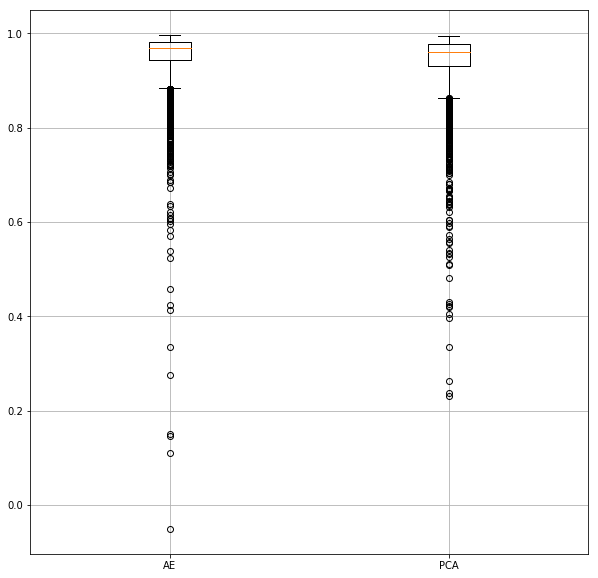

In [95]:
_, out = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE':out, 'PCA': out_pca}
find_correlation_coeff(d)

## Shallow Encoder - Deep Decoder Variation 2

In [38]:
# # input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

# class autoencoder_6(nn.Module):
#     def __init__(self, input_size, embedding_size):
#         super(autoencoder_6, self).__init__()
#         activation_layer = nn.LeakyReLU()
#         self.encoder = nn.Sequential(nn.Linear(input_size, 80),
#                                      activation_layer,
#                                      nn.Linear(80, 40),
#                                      activation_layer,
#                                      nn.BatchNorm1d(40),
#                                      nn.Linear(40, 25),
#                                      activation_layer,
#                                      nn.BatchNorm1d(25),
#                                      nn.Linear(25, 15),
#                                      activation_layer,
#                                      nn.BatchNorm1d(15),
#                                      nn.Linear(15, 10),
#                                      activation_layer,
#                                      nn.BatchNorm1d(10),
#                                      nn.Linear(10, embedding_size))
#         self.decoder = nn.Sequential(nn.Linear(embedding_size, 10),
#                                      activation_layer,
#                                      nn.BatchNorm1d(10),
#                                      nn.Linear(10, 25),
#                                      activation_layer,
#                                      nn.BatchNorm1d(25),
#                                      nn.Linear(25, 80),
#                                      activation_layer,
#                                      nn.Linear(80, input_size))
    
#     def forward(self, x):
#         enc = self.encoder(x)
#         dec = self.decoder(enc)
#         return enc, dec

In [107]:
class autoencoder_6(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_6, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 25),
                                     activation_layer,
                                     nn.Linear(25, 16),
                                     activation_layer,
                                     nn.Linear(16, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [39]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

In [43]:
# train_lim = int(0.8*electrode_data.shape[0])
# electrode_data_train = electrode_data[:train_lim, :]
# electrode_data_test = electrode_data[train_lim:, :]

# print("Training Datasize:", electrode_data_train.shape)
# print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (21169, 51)
Test Datasize: (5293, 51)


In [108]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 200000
batch_size = 250
learning_rate = 0.00005

embedding_size = 4

ae_64 = autoencoder_6(length, embedding_size).cuda()
ae_64.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_64.parameters(), lr=learning_rate)

enc, out, losses_64 = train_ae(ae_64, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_62 = autoencoder_6(length, embedding_size).cuda()
ae_62.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_62.parameters(), lr=learning_rate)

enc, out, losses_62 = train_ae(ae_62, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/new_data_models/losses_6_4', np.array(losses_64))
np.save('models/new_data_models/losses_6_2', np.array(losses_62))


# Saving Models
torch.save(ae_64, 'models/new_data_models/ae_6_4.pt') #Saving the autoencoder model
torch.save(ae_62, 'models/new_data_models/ae_6_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 10041
epoch [1/200000], loss:1891.79101562, avg:1891.79101562
epoch [101/200000], loss:1765.72741699, avg:1766.33813477
epoch [201/200000], loss:1644.15429688, avg:1632.26599121
epoch [301/200000], loss:1308.79846191, avg:1335.29870605
epoch [401/200000], loss:947.27655029, avg:965.47814941
epoch [501/200000], loss:610.14233398, avg:618.01336670
epoch [601/200000], loss:379.74826050, avg:373.10894775
epoch [701/200000], loss:264.56704712, avg:273.11459351
epoch [801/200000], loss:224.23767090, avg:241.29966736
epoch [901/200000], loss:217.50605774, avg:226.40904236
epoch [1001/200000], loss:209.66117859, avg:221.13487244
epoch [1101/200000], loss:224.81826782, avg:228.22142029
epoch [1201/200000], loss:211.14706421, avg:220.69282532
epoch [1301/200000], loss:230.06106567, avg:216.42822266
epoch [1401/200000], loss:221.41044617, avg:215.95327759
epoch [1501/200000], loss:219.52740479, avg:219.17822266
epoch [1601/200000], loss:202.20745850, avg:205.81411743
e

epoch [14601/200000], loss:76.09908295, avg:76.34103394
epoch [14701/200000], loss:69.47154999, avg:74.54524994
epoch [14801/200000], loss:72.76772308, avg:76.82137299
epoch [14901/200000], loss:80.16788483, avg:74.94310760
epoch [15001/200000], loss:76.60716248, avg:76.75818634
epoch [15101/200000], loss:71.18556976, avg:74.99346924
epoch [15201/200000], loss:82.03443146, avg:76.04857635
epoch [15301/200000], loss:75.37789917, avg:74.40119934
epoch [15401/200000], loss:75.62796783, avg:76.07702637
epoch [15501/200000], loss:76.77110291, avg:74.97612762
epoch [15601/200000], loss:75.66229248, avg:74.70397186
epoch [15701/200000], loss:75.90044403, avg:75.16470337
epoch [15801/200000], loss:70.60021973, avg:73.63259125
epoch [15901/200000], loss:79.97073364, avg:77.60211182
epoch [16001/200000], loss:74.65663147, avg:75.96753693
epoch [16101/200000], loss:74.30605316, avg:76.64695740
epoch [16201/200000], loss:78.12260437, avg:75.93005371
epoch [16301/200000], loss:73.22859192, avg:76.0

epoch [29301/200000], loss:71.94628143, avg:74.15431976
epoch [29401/200000], loss:79.53153229, avg:73.86711884
epoch [29501/200000], loss:75.60572815, avg:77.27710724
epoch [29601/200000], loss:72.25000763, avg:76.10268402
epoch [29701/200000], loss:73.35327148, avg:76.27816010
epoch [29801/200000], loss:78.60669708, avg:74.01784515
epoch [29901/200000], loss:76.65338135, avg:76.68810272
epoch [30001/200000], loss:72.52697754, avg:74.69725037
epoch [30101/200000], loss:70.77078247, avg:73.93829346
epoch [30201/200000], loss:68.87362671, avg:73.10021210
epoch [30301/200000], loss:77.41245270, avg:76.01446533
epoch [30401/200000], loss:77.13479614, avg:75.95220947
epoch [30501/200000], loss:77.96789551, avg:75.37187195
epoch [30601/200000], loss:76.46482086, avg:74.45851898
epoch [30701/200000], loss:74.47247314, avg:76.28002167
epoch [30801/200000], loss:71.67308044, avg:74.01206970
epoch [30901/200000], loss:78.44676971, avg:74.91425323
epoch [31001/200000], loss:78.28383636, avg:75.4

epoch [44001/200000], loss:75.12162781, avg:75.08080292
epoch [44101/200000], loss:73.29614258, avg:71.89009094
epoch [44201/200000], loss:70.94102478, avg:74.26186371
epoch [44301/200000], loss:80.22908020, avg:76.51752472
epoch [44401/200000], loss:73.93495178, avg:75.60311890
epoch [44501/200000], loss:76.30530548, avg:75.01986694
epoch [44601/200000], loss:77.40569305, avg:74.20504761
epoch [44701/200000], loss:73.96494293, avg:73.95859528
epoch [44801/200000], loss:73.35750580, avg:73.98673248
epoch [44901/200000], loss:69.17321777, avg:73.09889984
epoch [45001/200000], loss:77.10401154, avg:74.87355804
epoch [45101/200000], loss:77.67356110, avg:76.53325653
epoch [45201/200000], loss:78.53601837, avg:75.65179443
epoch [45301/200000], loss:75.93756866, avg:73.96858978
epoch [45401/200000], loss:76.19557190, avg:72.19491577
epoch [45501/200000], loss:75.41451263, avg:74.89892578
epoch [45601/200000], loss:77.40573120, avg:76.74324799
epoch [45701/200000], loss:78.10069275, avg:74.5

epoch [58701/200000], loss:77.11278534, avg:75.12714386
epoch [58801/200000], loss:79.11025238, avg:75.69675446
epoch [58901/200000], loss:79.03244781, avg:75.69483185
epoch [59001/200000], loss:78.05847168, avg:74.56391144
epoch [59101/200000], loss:73.36524200, avg:73.75318909
epoch [59201/200000], loss:75.88021088, avg:75.88092804
epoch [59301/200000], loss:77.42951202, avg:74.89770508
epoch [59401/200000], loss:73.12889099, avg:74.17481232
epoch [59501/200000], loss:74.46427917, avg:75.25509644
epoch [59601/200000], loss:77.64340210, avg:73.52610016
epoch [59701/200000], loss:76.65551758, avg:74.78488922
epoch [59801/200000], loss:71.55787659, avg:75.11814880
epoch [59901/200000], loss:74.92875671, avg:75.72715759
epoch [60001/200000], loss:81.02622986, avg:75.18900299
epoch [60101/200000], loss:82.13472748, avg:76.26787567
epoch [60201/200000], loss:69.82936096, avg:73.84404755
epoch [60301/200000], loss:74.55385590, avg:73.52458191
epoch [60401/200000], loss:73.16773224, avg:74.7

epoch [73401/200000], loss:80.32292175, avg:75.72814178
epoch [73501/200000], loss:76.21230316, avg:73.07759857
epoch [73601/200000], loss:72.91654205, avg:74.19441986
epoch [73701/200000], loss:76.13311005, avg:73.77131653
epoch [73801/200000], loss:75.87151337, avg:72.06144714
epoch [73901/200000], loss:73.03729248, avg:75.21126556
epoch [74001/200000], loss:70.15044403, avg:72.72768402
epoch [74101/200000], loss:72.77233124, avg:74.18129730
epoch [74201/200000], loss:73.26741028, avg:72.95319366
epoch [74301/200000], loss:71.44182587, avg:72.37430573
epoch [74401/200000], loss:74.23480988, avg:73.91489410
epoch [74501/200000], loss:76.96756744, avg:73.40346527
epoch [74601/200000], loss:73.74577332, avg:73.95919800
epoch [74701/200000], loss:72.13967133, avg:73.62911224
epoch [74801/200000], loss:75.81134796, avg:73.27319336
epoch [74901/200000], loss:73.61252594, avg:72.74002075
epoch [75001/200000], loss:79.83393097, avg:76.48531342
epoch [75101/200000], loss:70.47770691, avg:72.0

epoch [88101/200000], loss:69.34371948, avg:73.62806702
epoch [88201/200000], loss:77.76638031, avg:75.03217316
epoch [88301/200000], loss:73.80503082, avg:74.75139618
epoch [88401/200000], loss:70.89724731, avg:72.17402649
epoch [88501/200000], loss:69.99679565, avg:73.60485840
epoch [88601/200000], loss:75.17517853, avg:73.11141205
epoch [88701/200000], loss:71.09102631, avg:73.68309021
epoch [88801/200000], loss:76.64010620, avg:74.81665039
epoch [88901/200000], loss:71.03586578, avg:73.57614899
epoch [89001/200000], loss:76.33816528, avg:74.17769623
epoch [89101/200000], loss:77.75119781, avg:73.05679321
epoch [89201/200000], loss:75.28643799, avg:73.01921844
epoch [89301/200000], loss:70.66581726, avg:72.90032196
epoch [89401/200000], loss:74.23091888, avg:73.53180695
epoch [89501/200000], loss:73.94525146, avg:73.56761932
epoch [89601/200000], loss:78.47805023, avg:74.26329041
epoch [89701/200000], loss:74.56462860, avg:75.13413239
epoch [89801/200000], loss:76.92541504, avg:74.1

epoch [102701/200000], loss:68.44029999, avg:73.41677094
epoch [102801/200000], loss:73.44966888, avg:74.07793427
epoch [102901/200000], loss:74.51037598, avg:72.35807037
epoch [103001/200000], loss:76.64434814, avg:74.30702972
epoch [103101/200000], loss:77.48976135, avg:74.52793884
epoch [103201/200000], loss:72.78239441, avg:73.26232147
epoch [103301/200000], loss:70.23841858, avg:72.29634094
epoch [103401/200000], loss:76.89491272, avg:72.71738434
epoch [103501/200000], loss:70.18672180, avg:71.05544281
epoch [103601/200000], loss:74.20487976, avg:72.67491150
epoch [103701/200000], loss:71.64239502, avg:74.42234039
epoch [103801/200000], loss:71.49216461, avg:73.86923981
epoch [103901/200000], loss:74.15675354, avg:72.84410858
epoch [104001/200000], loss:70.33432007, avg:73.02317047
epoch [104101/200000], loss:74.06226349, avg:74.20708466
epoch [104201/200000], loss:75.32673645, avg:73.63518524
epoch [104301/200000], loss:68.69511414, avg:74.44496918
epoch [104401/200000], loss:74.

epoch [117101/200000], loss:74.43003082, avg:72.67780304
epoch [117201/200000], loss:71.54618835, avg:72.10189056
epoch [117301/200000], loss:71.06755066, avg:73.00763702
epoch [117401/200000], loss:74.81593323, avg:71.57588959
epoch [117501/200000], loss:74.48042297, avg:73.65624237
epoch [117601/200000], loss:70.80873871, avg:73.36700439
epoch [117701/200000], loss:75.13232422, avg:72.98906708
epoch [117801/200000], loss:70.45164490, avg:71.32396698
epoch [117901/200000], loss:71.29700470, avg:71.26631927
epoch [118001/200000], loss:76.68377686, avg:73.91893768
epoch [118101/200000], loss:71.35395813, avg:72.12560272
epoch [118201/200000], loss:70.86062622, avg:73.08083344
epoch [118301/200000], loss:77.57232666, avg:72.42504120
epoch [118401/200000], loss:70.14566803, avg:72.85293579
epoch [118501/200000], loss:72.39495850, avg:72.83589935
epoch [118601/200000], loss:69.45259857, avg:72.51851654
epoch [118701/200000], loss:72.63793945, avg:74.02510834
epoch [118801/200000], loss:70.

epoch [131501/200000], loss:70.78061676, avg:70.77339935
epoch [131601/200000], loss:69.09778595, avg:72.14455414
epoch [131701/200000], loss:69.18678284, avg:70.67079926
epoch [131801/200000], loss:76.50952911, avg:71.65377808
epoch [131901/200000], loss:74.54895782, avg:71.32329559
epoch [132001/200000], loss:76.71878052, avg:71.67716217
epoch [132101/200000], loss:71.66831970, avg:72.48744202
epoch [132201/200000], loss:76.11572266, avg:71.71963501
epoch [132301/200000], loss:67.82700348, avg:71.74701691
epoch [132401/200000], loss:70.28351593, avg:72.25264740
epoch [132501/200000], loss:69.73934174, avg:71.30606079
epoch [132601/200000], loss:70.75147247, avg:72.00461578
epoch [132701/200000], loss:68.90204620, avg:71.81759644
epoch [132801/200000], loss:71.96913147, avg:71.52297211
epoch [132901/200000], loss:69.70368958, avg:72.88438416
epoch [133001/200000], loss:74.31902313, avg:71.12471008
epoch [133101/200000], loss:72.32985687, avg:72.62565613
epoch [133201/200000], loss:72.

epoch [145901/200000], loss:69.87003326, avg:71.42211914
epoch [146001/200000], loss:74.69619751, avg:73.81966400
epoch [146101/200000], loss:71.00547791, avg:71.42441559
epoch [146201/200000], loss:70.18089294, avg:70.85505676
epoch [146301/200000], loss:69.78421021, avg:72.40288544
epoch [146401/200000], loss:74.76067352, avg:72.42710114
epoch [146501/200000], loss:73.33897400, avg:72.34049988
epoch [146601/200000], loss:68.68693542, avg:70.25527191
epoch [146701/200000], loss:66.12716675, avg:72.17531586
epoch [146801/200000], loss:66.39070892, avg:71.33383942
epoch [146901/200000], loss:75.79543304, avg:71.36342621
epoch [147001/200000], loss:74.29584503, avg:71.83763885
epoch [147101/200000], loss:65.64393616, avg:68.93299866
epoch [147201/200000], loss:74.41385651, avg:71.22625732
epoch [147301/200000], loss:74.42553711, avg:71.48209381
epoch [147401/200000], loss:70.87021637, avg:71.18621063
epoch [147501/200000], loss:70.62547302, avg:70.70232391
epoch [147601/200000], loss:70.

epoch [160301/200000], loss:72.50209808, avg:72.05764771
epoch [160401/200000], loss:69.01608276, avg:72.63851166
epoch [160501/200000], loss:73.28053284, avg:71.96810150
epoch [160601/200000], loss:69.33719635, avg:69.30331421
epoch [160701/200000], loss:73.43512726, avg:72.25826263
epoch [160801/200000], loss:76.04172516, avg:72.40112305
epoch [160901/200000], loss:71.95981598, avg:70.83274078
epoch [161001/200000], loss:70.50816345, avg:72.15877533
epoch [161101/200000], loss:68.95613098, avg:71.76668549
epoch [161201/200000], loss:74.24165344, avg:71.91121674
epoch [161301/200000], loss:66.48765564, avg:70.38802338
epoch [161401/200000], loss:68.79458618, avg:71.03160858
epoch [161501/200000], loss:69.16559601, avg:72.62126923
epoch [161601/200000], loss:72.30796814, avg:71.10256195
epoch [161701/200000], loss:68.31507111, avg:71.72598267
epoch [161801/200000], loss:68.94155121, avg:71.00937653
epoch [161901/200000], loss:72.76373291, avg:71.73713684
epoch [162001/200000], loss:72.

epoch [174701/200000], loss:69.53701782, avg:70.82881927
epoch [174801/200000], loss:69.18846893, avg:70.34392548
epoch [174901/200000], loss:74.59661102, avg:71.78591919
epoch [175001/200000], loss:69.81099701, avg:71.96810913
epoch [175101/200000], loss:67.66296387, avg:71.17134857
epoch [175201/200000], loss:65.00137329, avg:70.15901184
epoch [175301/200000], loss:70.23397827, avg:70.89127350
epoch [175401/200000], loss:72.27663422, avg:70.31864929
epoch [175501/200000], loss:70.73031616, avg:71.14049530
epoch [175601/200000], loss:67.16102600, avg:71.23731232
epoch [175701/200000], loss:71.22141266, avg:70.99999237
epoch [175801/200000], loss:67.68938446, avg:69.34693909
epoch [175901/200000], loss:70.87175751, avg:71.21916962
epoch [176001/200000], loss:68.00678253, avg:71.22231293
epoch [176101/200000], loss:72.97836304, avg:70.35540009
epoch [176201/200000], loss:70.97384644, avg:71.10703278
epoch [176301/200000], loss:76.49949646, avg:70.93856049
epoch [176401/200000], loss:70.

epoch [189101/200000], loss:72.73943329, avg:70.70356750
epoch [189201/200000], loss:68.72383118, avg:70.68537903
epoch [189301/200000], loss:69.29035950, avg:70.50035858
epoch [189401/200000], loss:68.46151733, avg:69.47078705
epoch [189501/200000], loss:68.90032196, avg:69.74365997
epoch [189601/200000], loss:70.12570953, avg:69.82082367
epoch [189701/200000], loss:68.95626831, avg:69.30444336
epoch [189801/200000], loss:68.32004547, avg:71.36995697
epoch [189901/200000], loss:70.99921417, avg:69.37841034
epoch [190001/200000], loss:70.75531006, avg:69.72248840
epoch [190101/200000], loss:72.30043793, avg:71.99849701
epoch [190201/200000], loss:71.10800171, avg:69.69056702
epoch [190301/200000], loss:66.71946716, avg:70.03495026
epoch [190401/200000], loss:68.57232666, avg:71.01505280
epoch [190501/200000], loss:70.38426208, avg:69.27941895
epoch [190601/200000], loss:74.99548340, avg:72.30257416
epoch [190701/200000], loss:71.25717926, avg:70.14228058
epoch [190801/200000], loss:73.

epoch [3501/200000], loss:143.93974304, avg:144.25860596
epoch [3601/200000], loss:152.63578796, avg:147.17233276
epoch [3701/200000], loss:141.98628235, avg:147.54499817
epoch [3801/200000], loss:150.22637939, avg:147.89118958
epoch [3901/200000], loss:138.36213684, avg:144.35766602
epoch [4001/200000], loss:148.98677063, avg:146.80796814
epoch [4101/200000], loss:151.09107971, avg:148.27574158
epoch [4201/200000], loss:134.93310547, avg:147.22064209
epoch [4301/200000], loss:141.25679016, avg:145.50663757
epoch [4401/200000], loss:141.95759583, avg:143.74798584
epoch [4501/200000], loss:139.90534973, avg:145.65715027
epoch [4601/200000], loss:148.94288635, avg:149.57963562
epoch [4701/200000], loss:152.08291626, avg:144.73637390
epoch [4801/200000], loss:135.64234924, avg:140.84092712
epoch [4901/200000], loss:149.11373901, avg:144.40779114
epoch [5001/200000], loss:147.61550903, avg:143.97929382
epoch [5101/200000], loss:127.83904266, avg:140.33914185
epoch [5201/200000], loss:145.7

epoch [17801/200000], loss:144.56532288, avg:145.29742432
epoch [17901/200000], loss:139.11788940, avg:143.55113220
epoch [18001/200000], loss:132.98974609, avg:143.53439331
epoch [18101/200000], loss:124.66577148, avg:143.09454346
epoch [18201/200000], loss:131.32130432, avg:140.65628052
epoch [18301/200000], loss:126.14437103, avg:142.11303711
epoch [18401/200000], loss:146.05171204, avg:142.12205505
epoch [18501/200000], loss:127.48355865, avg:145.54791260
epoch [18601/200000], loss:142.04374695, avg:139.34190369
epoch [18701/200000], loss:136.74462891, avg:140.85720825
epoch [18801/200000], loss:142.38725281, avg:143.88159180
epoch [18901/200000], loss:145.44468689, avg:143.36259460
epoch [19001/200000], loss:151.94393921, avg:142.89562988
epoch [19101/200000], loss:146.03416443, avg:141.38032532
epoch [19201/200000], loss:148.06681824, avg:141.32884216
epoch [19301/200000], loss:134.54418945, avg:138.86949158
epoch [19401/200000], loss:141.96229553, avg:141.84687805
epoch [19501/2

epoch [32001/200000], loss:131.36846924, avg:136.68150330
epoch [32101/200000], loss:148.61947632, avg:137.92657471
epoch [32201/200000], loss:134.62281799, avg:136.95658875
epoch [32301/200000], loss:135.12347412, avg:136.47953796
epoch [32401/200000], loss:133.70262146, avg:135.46888733
epoch [32501/200000], loss:128.14903259, avg:133.88201904
epoch [32601/200000], loss:128.68919373, avg:134.09074402
epoch [32701/200000], loss:129.18084717, avg:135.63516235
epoch [32801/200000], loss:128.66810608, avg:141.38388062
epoch [32901/200000], loss:138.78428650, avg:135.07241821
epoch [33001/200000], loss:139.96171570, avg:139.36495972
epoch [33101/200000], loss:141.06230164, avg:136.44111633
epoch [33201/200000], loss:144.63285828, avg:137.23695374
epoch [33301/200000], loss:137.17407227, avg:135.35455322
epoch [33401/200000], loss:140.58479309, avg:139.07713318
epoch [33501/200000], loss:131.02804565, avg:137.70812988
epoch [33601/200000], loss:150.49162292, avg:139.42982483
epoch [33701/2

epoch [46201/200000], loss:139.53295898, avg:138.67674255
epoch [46301/200000], loss:133.90544128, avg:132.22465515
epoch [46401/200000], loss:131.70025635, avg:134.68045044
epoch [46501/200000], loss:140.52394104, avg:138.83921814
epoch [46601/200000], loss:125.35876465, avg:135.31242371
epoch [46701/200000], loss:134.83190918, avg:137.29257202
epoch [46801/200000], loss:130.95054626, avg:133.98478699
epoch [46901/200000], loss:131.24781799, avg:132.83343506
epoch [47001/200000], loss:136.11775208, avg:136.49067688
epoch [47101/200000], loss:123.63032532, avg:131.81465149
epoch [47201/200000], loss:130.82310486, avg:136.70945740
epoch [47301/200000], loss:137.46145630, avg:133.32887268
epoch [47401/200000], loss:138.88801575, avg:135.72709656
epoch [47501/200000], loss:127.07522583, avg:130.47346497
epoch [47601/200000], loss:138.71963501, avg:135.39454651
epoch [47701/200000], loss:140.56987000, avg:139.64089966
epoch [47801/200000], loss:142.74943542, avg:139.31332397
epoch [47901/2

epoch [60401/200000], loss:129.50564575, avg:131.49075317
epoch [60501/200000], loss:139.21929932, avg:136.23356628
epoch [60601/200000], loss:124.74436951, avg:131.01231384
epoch [60701/200000], loss:130.60668945, avg:133.30657959
epoch [60801/200000], loss:130.29910278, avg:134.31347656
epoch [60901/200000], loss:131.27101135, avg:131.00686646
epoch [61001/200000], loss:131.04309082, avg:131.70495605
epoch [61101/200000], loss:146.29104614, avg:133.64558411
epoch [61201/200000], loss:131.56004333, avg:132.93768311
epoch [61301/200000], loss:128.50048828, avg:133.29487610
epoch [61401/200000], loss:138.07975769, avg:133.36137390
epoch [61501/200000], loss:130.83126831, avg:129.06521606
epoch [61601/200000], loss:129.24118042, avg:132.60166931
epoch [61701/200000], loss:136.44184875, avg:132.96759033
epoch [61801/200000], loss:129.49771118, avg:129.93112183
epoch [61901/200000], loss:143.32774353, avg:132.67442322
epoch [62001/200000], loss:132.38819885, avg:136.71046448
epoch [62101/2

epoch [74601/200000], loss:121.85494232, avg:131.42132568
epoch [74701/200000], loss:133.48858643, avg:133.90989685
epoch [74801/200000], loss:136.47122192, avg:130.93844604
epoch [74901/200000], loss:136.95758057, avg:137.09873962
epoch [75001/200000], loss:126.26565552, avg:131.40629578
epoch [75101/200000], loss:123.04451752, avg:133.16447449
epoch [75201/200000], loss:123.67935181, avg:135.09136963
epoch [75301/200000], loss:135.82015991, avg:131.59725952
epoch [75401/200000], loss:130.38526917, avg:132.02836609
epoch [75501/200000], loss:142.16436768, avg:132.61502075
epoch [75601/200000], loss:143.27177429, avg:134.87464905
epoch [75701/200000], loss:135.64605713, avg:130.86755371
epoch [75801/200000], loss:125.54158020, avg:131.21182251
epoch [75901/200000], loss:128.47511292, avg:131.67527771
epoch [76001/200000], loss:134.34606934, avg:132.28991699
epoch [76101/200000], loss:128.96406555, avg:129.84342957
epoch [76201/200000], loss:128.89483643, avg:132.32254028
epoch [76301/2

epoch [88801/200000], loss:131.20396423, avg:130.04858398
epoch [88901/200000], loss:124.63733673, avg:129.95748901
epoch [89001/200000], loss:139.55908203, avg:135.54211426
epoch [89101/200000], loss:123.73864746, avg:129.43894958
epoch [89201/200000], loss:132.95361328, avg:127.91694641
epoch [89301/200000], loss:137.16497803, avg:130.28999329
epoch [89401/200000], loss:125.43952942, avg:132.48924255
epoch [89501/200000], loss:121.60746002, avg:127.27941132
epoch [89601/200000], loss:131.18402100, avg:132.89353943
epoch [89701/200000], loss:135.14686584, avg:135.20700073
epoch [89801/200000], loss:131.52832031, avg:129.70324707
epoch [89901/200000], loss:135.16217041, avg:135.85314941
epoch [90001/200000], loss:128.74389648, avg:128.96025085
epoch [90101/200000], loss:137.87078857, avg:133.15412903
epoch [90201/200000], loss:141.47218323, avg:134.39231873
epoch [90301/200000], loss:132.52984619, avg:132.81277466
epoch [90401/200000], loss:148.55949402, avg:130.12271118
epoch [90501/2

epoch [102901/200000], loss:125.34377289, avg:131.74394226
epoch [103001/200000], loss:139.10871887, avg:133.34138489
epoch [103101/200000], loss:130.02267456, avg:131.85583496
epoch [103201/200000], loss:140.19483948, avg:132.17341614
epoch [103301/200000], loss:132.72280884, avg:131.49485779
epoch [103401/200000], loss:132.77223206, avg:129.77662659
epoch [103501/200000], loss:117.72357941, avg:131.84666443
epoch [103601/200000], loss:137.02455139, avg:132.20970154
epoch [103701/200000], loss:125.02060699, avg:130.10887146
epoch [103801/200000], loss:137.33935547, avg:130.40597534
epoch [103901/200000], loss:134.28843689, avg:133.23356628
epoch [104001/200000], loss:128.78324890, avg:131.67497253
epoch [104101/200000], loss:139.02549744, avg:129.82931519
epoch [104201/200000], loss:128.74131775, avg:130.97610474
epoch [104301/200000], loss:126.83576202, avg:133.89549255
epoch [104401/200000], loss:134.24685669, avg:132.99963379
epoch [104501/200000], loss:137.11614990, avg:133.825027

epoch [116801/200000], loss:134.71237183, avg:131.22952271
epoch [116901/200000], loss:124.24423218, avg:131.09381104
epoch [117001/200000], loss:113.90582275, avg:129.48889160
epoch [117101/200000], loss:125.19609833, avg:131.06590271
epoch [117201/200000], loss:130.96447754, avg:132.54783630
epoch [117301/200000], loss:139.54904175, avg:133.61990356
epoch [117401/200000], loss:128.43737793, avg:130.82510376
epoch [117501/200000], loss:139.54643250, avg:131.12104797
epoch [117601/200000], loss:136.28405762, avg:135.82075500
epoch [117701/200000], loss:132.15180969, avg:132.64659119
epoch [117801/200000], loss:134.64964294, avg:129.82409668
epoch [117901/200000], loss:128.60125732, avg:129.39001465
epoch [118001/200000], loss:125.31227112, avg:133.65052795
epoch [118101/200000], loss:129.08502197, avg:131.32742310
epoch [118201/200000], loss:128.83540344, avg:128.11106873
epoch [118301/200000], loss:120.01637268, avg:127.62154388
epoch [118401/200000], loss:138.89356995, avg:131.359909

epoch [130701/200000], loss:127.37123871, avg:131.13340759
epoch [130801/200000], loss:129.16964722, avg:130.25895691
epoch [130901/200000], loss:139.57662964, avg:132.09983826
epoch [131001/200000], loss:124.41007233, avg:128.28485107
epoch [131101/200000], loss:132.28062439, avg:129.24530029
epoch [131201/200000], loss:122.49497986, avg:127.42069244
epoch [131301/200000], loss:129.38635254, avg:135.14607239
epoch [131401/200000], loss:132.35063171, avg:132.11134338
epoch [131501/200000], loss:136.39144897, avg:127.40962219
epoch [131601/200000], loss:139.71778870, avg:130.34841919
epoch [131701/200000], loss:123.41661072, avg:129.98875427
epoch [131801/200000], loss:144.18087769, avg:134.55381775
epoch [131901/200000], loss:141.42086792, avg:132.49523926
epoch [132001/200000], loss:131.26408386, avg:132.57659912
epoch [132101/200000], loss:121.48806763, avg:127.84189606
epoch [132201/200000], loss:133.46205139, avg:131.47479248
epoch [132301/200000], loss:132.04350281, avg:127.903526

epoch [144601/200000], loss:125.89408875, avg:131.25517273
epoch [144701/200000], loss:131.15556335, avg:132.35639954
epoch [144801/200000], loss:127.12207794, avg:136.48320007
epoch [144901/200000], loss:132.84718323, avg:132.28103638
epoch [145001/200000], loss:126.75337219, avg:130.83396912
epoch [145101/200000], loss:130.22628784, avg:135.97708130
epoch [145201/200000], loss:132.98202515, avg:136.06632996
epoch [145301/200000], loss:146.71716309, avg:135.55099487
epoch [145401/200000], loss:142.56639099, avg:127.86437225
epoch [145501/200000], loss:129.85397339, avg:132.40821838
epoch [145601/200000], loss:124.74981689, avg:130.29817200
epoch [145701/200000], loss:133.17829895, avg:131.26849365
epoch [145801/200000], loss:135.12219238, avg:134.12585449
epoch [145901/200000], loss:124.41740417, avg:131.22573853
epoch [146001/200000], loss:129.51109314, avg:131.09535217
epoch [146101/200000], loss:127.47492218, avg:132.01542664
epoch [146201/200000], loss:135.34660339, avg:132.599807

epoch [158501/200000], loss:139.55470276, avg:134.51686096
epoch [158601/200000], loss:127.24723816, avg:132.73893738
epoch [158701/200000], loss:141.28237915, avg:132.28616333
epoch [158801/200000], loss:125.95232391, avg:131.01165771
epoch [158901/200000], loss:123.11687469, avg:130.98820496
epoch [159001/200000], loss:137.44631958, avg:134.35356140
epoch [159101/200000], loss:132.62608337, avg:133.94551086
epoch [159201/200000], loss:129.33509827, avg:132.02793884
epoch [159301/200000], loss:131.52861023, avg:128.21464539
epoch [159401/200000], loss:132.10307312, avg:129.97082520
epoch [159501/200000], loss:126.77686310, avg:128.53511047
epoch [159601/200000], loss:138.17985535, avg:130.88751221
epoch [159701/200000], loss:135.33557129, avg:130.32380676
epoch [159801/200000], loss:134.35122681, avg:129.80960083
epoch [159901/200000], loss:132.80395508, avg:128.19059753
epoch [160001/200000], loss:142.73945618, avg:132.36415100
epoch [160101/200000], loss:129.16310120, avg:131.874969

epoch [172401/200000], loss:129.29972839, avg:129.86665344
epoch [172501/200000], loss:120.68640900, avg:131.32621765
epoch [172601/200000], loss:125.82795715, avg:131.69271851
epoch [172701/200000], loss:136.33387756, avg:129.78506470
epoch [172801/200000], loss:122.66519928, avg:131.23757935
epoch [172901/200000], loss:126.64037323, avg:128.69767761
epoch [173001/200000], loss:118.11933136, avg:132.81661987
epoch [173101/200000], loss:129.31192017, avg:129.79943848
epoch [173201/200000], loss:136.47074890, avg:129.75675964
epoch [173301/200000], loss:128.39108276, avg:130.58616638
epoch [173401/200000], loss:122.42664337, avg:131.43792725
epoch [173501/200000], loss:133.58331299, avg:131.14976501
epoch [173601/200000], loss:130.72499084, avg:131.32188416
epoch [173701/200000], loss:130.57176208, avg:131.76988220
epoch [173801/200000], loss:124.89208221, avg:129.64445496
epoch [173901/200000], loss:122.14232635, avg:134.65254211
epoch [174001/200000], loss:132.63839722, avg:133.278701

epoch [186301/200000], loss:141.41314697, avg:131.77412415
epoch [186401/200000], loss:130.65057373, avg:129.68013000
epoch [186501/200000], loss:130.92802429, avg:131.43016052
epoch [186601/200000], loss:134.42938232, avg:130.50645447
epoch [186701/200000], loss:132.43678284, avg:130.98376465
epoch [186801/200000], loss:118.42170715, avg:129.02748108
epoch [186901/200000], loss:144.31437683, avg:134.27600098
epoch [187001/200000], loss:135.64982605, avg:134.55084229
epoch [187101/200000], loss:128.07379150, avg:129.68037415
epoch [187201/200000], loss:131.08760071, avg:130.38421631
epoch [187301/200000], loss:134.43370056, avg:132.86950684
epoch [187401/200000], loss:121.55204010, avg:132.86178589
epoch [187501/200000], loss:126.22374725, avg:131.22073364
epoch [187601/200000], loss:131.61102295, avg:130.63552856
epoch [187701/200000], loss:128.80950928, avg:133.99035645
epoch [187801/200000], loss:128.81971741, avg:133.92521667
epoch [187901/200000], loss:117.86441803, avg:131.693435

In [109]:
ae_1 = torch.load('models/new_data_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/new_data_models/ae_6_4.pt', map_location=lambda storage, loc: storage)

AE 0.9430583089340949
PCA 0.9177600425485325


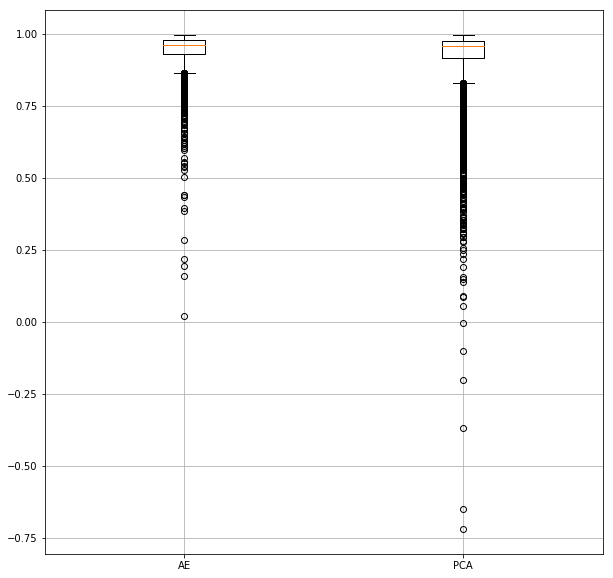

In [116]:
_, out = get_network_output(ae_1, 2)
out_pca = None
out_pca = comp_pca(0)
d = {'AE':out, 'PCA': out_pca}
find_correlation_coeff(d)

In [70]:
print(electrode_data_test[80])

[0.61788618 0.6504065  0.6504065  0.63143631 0.6504065  0.67208672
 0.64769648 0.62601626 0.61517615 0.58265583 0.54471545 0.52574526
 0.50135501 0.45528455 0.42276423 0.43360434 0.46883469 0.51490515
 0.55555556 0.58265583 0.60704607 0.64769648 0.69918699 0.73170732
 0.74254743 0.76422764 0.77235772 0.7696477  0.77235772 0.78590786
 0.79403794 0.77235772 0.76151762 0.7804878  0.79403794 0.77506775
 0.75067751 0.74796748 0.74254743 0.73170732 0.72357724 0.71273713
 0.71544715 0.70731707 0.69105691 0.70189702 0.71273713 0.7100271
 0.71544715 0.71544715 0.72628726]


In [71]:
print(out[80])

[0.6724678  0.6690039  0.6649095  0.65939033 0.6526978  0.6454996
 0.63663924 0.624905   0.61116564 0.5920311  0.56292987 0.52646506
 0.4792304  0.42010704 0.38626793 0.40888798 0.45800945 0.5018982
 0.54302454 0.5820803  0.61428946 0.6429044  0.6692382  0.69130474
 0.7104989  0.72777885 0.7415727  0.75209826 0.7605901  0.7668624
 0.7710865  0.77359825 0.7741254  0.77321756 0.7709651  0.7669374
 0.7619267  0.75656456 0.75127804 0.7467153  0.7425077  0.73793304
 0.7328384  0.72750163 0.72239023 0.7178234  0.7136     0.70991504
 0.7065864  0.70382845 0.7016198 ]


In [117]:
print(out_pca)

[[-5.948982   -7.25419245 -8.80093533 ...  4.49544145  3.54234966
   2.6019179 ]
 [-5.948982   -7.25419245 -8.80093533 ...  4.49544145  3.54234966
   2.6019179 ]
 [-5.948982   -7.25419245 -8.80093533 ...  4.49544145  3.54234966
   2.6019179 ]
 ...
 [-5.948982   -7.25419245 -8.80093533 ...  4.49544145  3.54234966
   2.6019179 ]
 [-5.948982   -7.25419245 -8.80093533 ...  4.49544145  3.54234966
   2.6019179 ]
 [-5.948982   -7.25419245 -8.80093533 ...  4.49544145  3.54234966
   2.6019179 ]]
